In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-uncased-local/bert/config.json
/kaggle/input/bert-uncased-local/bert/tokenizer_config.json
/kaggle/input/bert-uncased-local/bert/pytorch_model.bin
/kaggle/input/bert-uncased-local/bert/special_tokens_map.json
/kaggle/input/bert-uncased-local/bert/vocab.txt
/kaggle/input/bert-uncased-local/bert/added_tokens.json
/kaggle/input/amazon-product-reviews/Reviews.csv


In [4]:
import torch

# Automatically use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [5]:
df = pd.read_csv('/kaggle/input/amazon-product-reviews/Reviews.csv')

In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df.shape

(568454, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [10]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [11]:
df['ProfileName'] = df['ProfileName'].fillna('Anonymous')

In [12]:
df['Summary']=df['Summary'].fillna('No Summary')

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

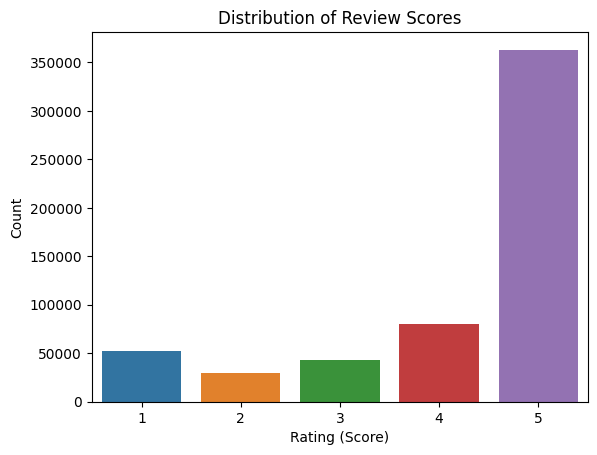

In [14]:
sns.countplot(x='Score', data = df)
plt.title('Distribution of Review Scores')
plt.xlabel('Rating (Score)')
plt.ylabel('Count')
plt.show()

In [15]:
df['Time'] = pd.to_datetime(df['Time'], unit = 's')
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month

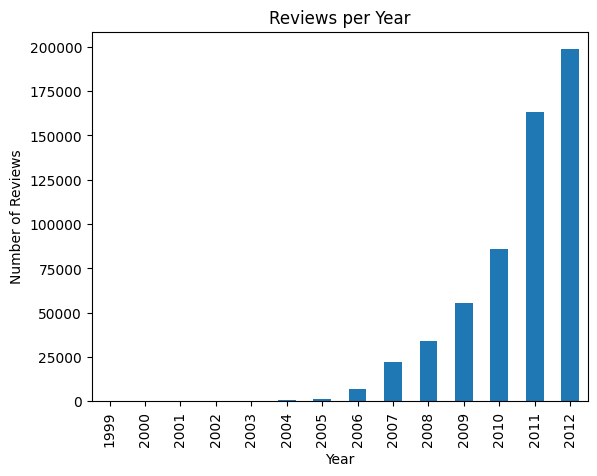

In [16]:
df['Year'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

In [17]:
df['HelpfulnessRatio'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator'].replace(0,1)

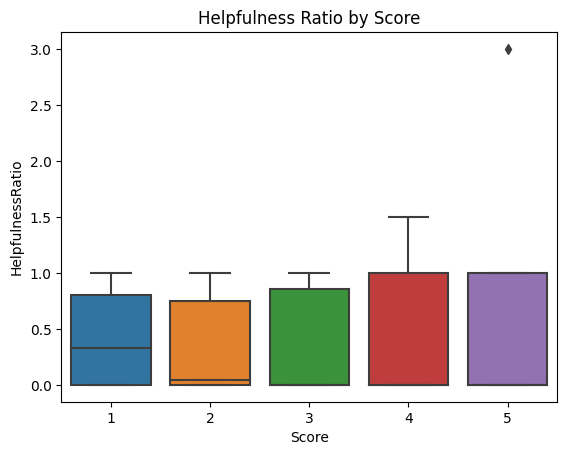

In [18]:
sns.boxplot(x='Score', y='HelpfulnessRatio', data=df)
plt.title('Helpfulness Ratio by Score')
plt.show()

In [19]:
df['TextLength'] = df['Text'].astype(str).apply(len)

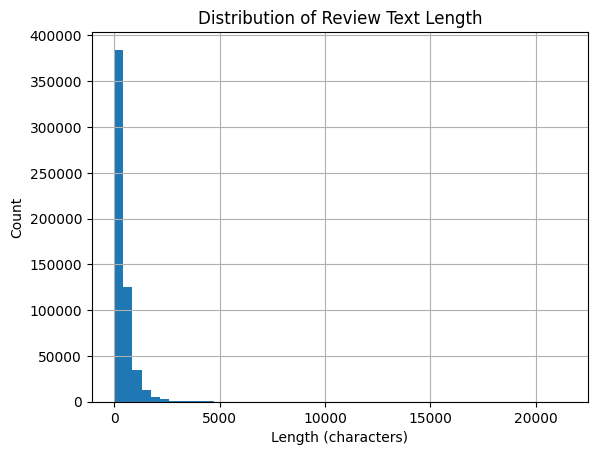

In [20]:
df['TextLength'].hist(bins=50)
plt.title('Distribution of Review Text Length')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

In [21]:
#Sentiment Classification
def map_score(score):
    if score in [1,2]:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

In [22]:
df['label'] = df['Score'].apply(map_score)

In [23]:
#Training and Testing Data Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size = 0.2,
    stratify = df['label'],
    random_state = 42
)

In [24]:
!ls /kaggle/input/bert-uncased-local/

bert


In [25]:
#Converting the entire text to string
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

In [26]:
from transformers import BertTokenizer, BertForSequenceClassification

2025-06-09 14:41:22.294288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749480082.773737      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749480082.896084      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
#Loading the bert model from hugging face
tokenizer = BertTokenizer.from_pretrained('/kaggle/input/bert-uncased-local/bert/')
model = BertForSequenceClassification.from_pretrained('/kaggle/input/bert-uncased-local/bert/', num_labels=3)

In [28]:
#Loading and encoding data
import torch
from tqdm import tqdm

def batch_tokenize(texts, batch_size = 2000):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch = tokenizer(
            batch_texts,
            truncation = True,
            padding = 'max_length',
            max_length = 128,
            return_tensors='pt'
        )
        input_ids.append(batch['input_ids'])
        attention_masks.append(batch['attention_mask'])
    return{
        'input_ids':torch.cat(input_ids, dim = 0),
        'attention_mask':torch.cat(attention_masks, dim=0)
    }

train_encodings = batch_tokenize(X_train,batch_size=2000)
test_encodings = batch_tokenize(X_test,batch_size=2000)

100%|██████████| 57/57 [02:29<00:00,  2.62s/it]


In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [30]:
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

In [31]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [32]:
batch_size = 16

In [33]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [34]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [36]:
optimizer = AdamW(model.parameters(), lr = 2e-5)

In [37]:
from transformers import get_scheduler
from torch.cuda.amp import GradScaler, autocast

In [38]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 2
num_training_steps = len(train_dataloader) * num_epochs

In [39]:
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [40]:
loss_fn = CrossEntropyLoss()
scaler = GradScaler()

/tmp/ipykernel_35/4103399072.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [41]:
#training on epochs
model.train()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    total_loss = 0

    for batch in tqdm(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        # Mixed precision forward and backward
        with autocast():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                labels=b_labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")


Epoch 1/2


  0%|          | 0/28423 [00:00<?, ?it/s]/tmp/ipykernel_35/3419738516.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 28423/28423 [1:00:27<00:00,  7.84it/s]


Average training loss: 0.2441

Epoch 2/2


100%|██████████| 28423/28423 [1:00:31<00:00,  7.83it/s]

Average training loss: 0.1459


In [42]:
model.save_pretrained("/kaggle/working/bert_sentiment_model")
tokenizer.save_pretrained("/kaggle/working/bert_sentiment_model")

print(" Model and tokenizer saved successfully!")

 Model and tokenizer saved successfully!


In [43]:
!zip -r /kaggle/working/bert_sentiment_model.zip /kaggle/working/bert_sentiment_model

  adding: kaggle/working/bert_sentiment_model/ (stored 0%)
  adding: kaggle/working/bert_sentiment_model/model.safetensors (deflated 7%)
  adding: kaggle/working/bert_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/bert_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/bert_sentiment_model/config.json (deflated 52%)
  adding: kaggle/working/bert_sentiment_model/vocab.txt (deflated 53%)


In [44]:
!mv bert_sentiment_model.zip /kaggle/working/

mv: 'bert_sentiment_model.zip' and '/kaggle/working/bert_sentiment_model.zip' are the same file


In [45]:
from sklearn.metrics import classification_report, accuracy_score

In [46]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [47]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask
        )

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())


In [48]:
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9361


In [49]:
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87     16407
     Neutral       0.69      0.61      0.65      8528
    Positive       0.97      0.98      0.97     88756

    accuracy                           0.94    113691
   macro avg       0.84      0.82      0.83    113691
weighted avg       0.93      0.94      0.93    113691



In [50]:
#Testing and Predicting on data
def predict_sentiment(text):
    model.eval()
    
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    # Move tensors to the appropriate device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Run the model
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    # Map prediction back to label
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map[prediction]


In [51]:
print(predict_sentiment("This product is amazing!"))

Positive


In [52]:
print(predict_sentiment("It's okay, not the best."))

Neutral


In [53]:
print(predict_sentiment("Worst experience ever, I want a refund."))

Negative
